In [1]:
import numpy as np
import pandas as pd
import os
import scipy
import tensorflow as tf
import keras

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from math import sqrt

from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import MinMaxScaler

from statistics import mean

from scipy.signal import savgol_filter
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon

from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import asarray

from keras import backend as K
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv1D
#from keras.layers import Conv1DTranspose
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import UpSampling1D

Using TensorFlow backend.


In [2]:
#Función para calcular las veces que duerme el paciente en nuestro set de datos
def numdays(data): 
    days = int()
    for j in range (len(data)-1):
        if data.iloc[j][3] == 0 and data.iloc[j][4] == 0:
                days = days + 1
        else:
                continue
    return days

In [3]:
#Función para convertir los datos de Glucosa en sangre al formato de la LSTM
def dataprocesshours (dataset):   
    #Cuantos datos del set de datos leemos
    timesteps = dataset.shape[0]-1   
    rows  = numdays(dataset)*int(24/hourstoprocess)
    processed = np.ones((rows, (hourstoprocess*12)))
    if workwith=='OHIO':
        Glucoseposition = 6
    elif workwith=='BCN':
        Glucoseposition = 6
    j = 0
    i = 0
    k = 0           
    for j in range (timesteps):
        if k == rows:           
            break
        else: 
            if i < (hourstoprocess*12)-1:
                processed[k][i] = dataset.iloc[j][Glucoseposition]
                i = i + 1
            elif i == (hourstoprocess*12)-1:
                processed[k][i] = dataset.iloc[j][Glucoseposition]
                k = k + 1
                i = 0
    return processed

In [4]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(hourstoprocess*6*200, activation='relu', input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((1, hourstoprocess*6*200)))
    model.add(UpSampling1D())
    model.add(Conv1D(288, 1, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling1D())
    model.add(Conv1D(288, 1, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.summary()
    return model

In [5]:
# define the standalone discriminator model
def define_discriminator():
    model = Sequential()
    
    model.add(Dense(288, activation='linear', input_dim=288))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((1, 288)))
    model.add(Conv1D(288, 1, activation='linear'))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.4))
    model.add(Conv1D(128, 1, activation='linear', padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=lr, beta_1=0.5)
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

In [6]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], size = n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [8]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=lr, beta_1=0.5)
    model.compile(loss=loss, optimizer='adam')
    return model

In [9]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs, n_batch, n_eval):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_epochs):
        
        # prepare real samples
        x_real, y_real = generate_real_samples(dataset, half_batch)
        
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)           
            
        _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
        _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

        discri_prediction_fake = discriminator.predict(x_fake)
        discri_prediction_real = discriminator.predict(x_real)
            
        if i%n_eval == 0:
            
            print('Iteration')
            print(i)
            print(' ')
            print('Fake:')
            print(discri_prediction_fake[:10])
            print(' ')
            print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
            print(' ')
            print('Real:')
            print(discri_prediction_real[:10])
            print(' ')
            
            '''not_valid = hypocount(fake_smoothing(x_fake))[2]
            fake_w = hypocount(fake_smoothing(x_fake))[0]
            fake_s = hypocount(fake_smoothing(x_fake))[1]
            
            print('real weak hypos:', real_w)
            print('fake weak hypos:', fake_w)
            print('real strong hypos:', real_s)
            print('fake strong hypos:', fake_s)
            print('NON VALID DATA:', not_valid)
            print(' ')
            print('NO HYPO REAL DATA:', real_nohypo)
            print('NO HYPO FAKE DATA:', hypocount(fake_smoothing(x_fake))[3])

            if (abs(real_w-fake_w)/half_batch) < 0.1 and (abs(real_s-fake_s)/half_batch < 0.1) and (not_valid/half_batch<0.1):
                #and (not_valid/half_batch < 0.15)
                print('VALID SOLUTION ACHIEVED AT: '+str(i)+' EPOCHS')
                # example of calculating the js divergence between two mass functions
                corr_matrix_js_pq = np.ones((n_samples,n_samples))
                corr_matrix_js_pq_real = np.ones((n_samples,n_samples))
                corr_matrix_js_pq_fake = np.ones((n_samples,n_samples))
                fake_smooth= fake_smoothing(x_fake)
                for a in range (half_batch):
                    for j in range(half_batch):

                        p=asarray(x_real[a])
                        q=asarray(fake_smooth[j])
                        corr_matrix_js_pq[a][j] = jensenshannon(p, q, base=2)

                for a in range (half_batch):
                    for j in range(half_batch):

                        p=asarray(x_real[a])
                        q=asarray(x_real[j])
                        corr_matrix_js_pq_real[a][j] = jensenshannon(p, q, base=2)
                        
                        p=asarray(fake_smooth[a])
                        q=asarray(fake_smooth[j])
                        corr_matrix_js_pq_fake[a][j] = jensenshannon(p, q, base=2)
                
                mean_rf =(np.around(np.nanmean(corr_matrix_js_pq), decimals=3))
                mean_rr =(np.around(np.nanmean(corr_matrix_js_pq_real), decimals=3))
                mean_ff =(np.around(np.nanmean(corr_matrix_js_pq_fake), decimals=3))
                
                if (abs(mean_rf-mean_rr)/mean_rr)<=0.15 and (abs(mean_ff-mean_rr)/mean_rr)<=0.40:
                    print('Variate Distribution')
                    directory = direct+'MODELS'
                    filename = 'generator_model_conv1D'+'COMPLETED_MODEL'+workwith+str(hourstoprocess)+'h.h5'
                    generator.save(os.path.join(directory, filename))
                    print('VALID MODEL SAVED')'''                   
                
            plt.plot(x_fake[0])
            plt.plot(x_fake[1])
            plt.plot(x_fake[2])
            
            plt.show()
            
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        x, y = vstack((x_real, x_fake)), vstack((y_real, y_fake))
        d_loss, _ = d_model.train_on_batch(x, y)
        g_loss = gan_model.train_on_batch(x_gan, y_gan)           

In [10]:
def readprocessed (datain):
    
    dataout = np.ones((datain.shape[0],datain.shape[1]))  

    for j in range (len(dataout)):
        for i in range (len(dataout[0])):
            dataout[j][i] = datain.iloc[j][i]
            
    return dataout

In [11]:
#Función para interpolar los datos con espacios sin información a causa de fallo con el sensor

def datafill (datain):
    
    auxvector = np.ones(len(datain[0])-1)
    dataout = np.ones((len(datain), len(datain[0])))  

    for j in range (len(datain)):
        
        for i in range (len(auxvector)):
            
            #Vector fila que vamos a interpolar
            auxvector[i] = datain[j][i]
            
            #Si el valor en un punto es 0 (falla no continuada)
            if auxvector[i] == 0:
                auxvector[i] = np.nan
            else:
                continue
            
        #Interpolar los valores que no tenemos    
        auxvector = pd.Series(auxvector)
        auxvector = round(auxvector.interpolate())
        dataout[j][:(len(datain[0])-1)] = auxvector[:]
                
        #Último valor (salida) siempre és igual al entrar que al salir de la función, no se interpola    
        dataout[j][len(datain[0])-1] = datain[j][len(datain[0])-1]
              
    return(dataout)

In [12]:
#Encontrar el valor mayor y menor del set de datos para usarlo al escalar entre 0 y 1
def maxmin(datain):
    
    maximo = 0
    minimo = 0
    valores = np.ones(2)
    for j in range (len(datain)):
        if valores[0] <= max(datain[j]):
            valores[0] = max(datain[j])
        else:
            continue
        if valores[1] >= min(datain[j]):
            valores[1] = min(datain[j])
        else: 
            continue
    return valores

In [13]:
def dataclean(datain,datain2):
    def delatevector(datain):

        delate = [] 
        dataout = np.ones((len(datain), len(datain[0])))  

        for j in range (len(datain)):
            fallida = 0
            if datain[j][0]<40 or datain[j][len(datain[0])-1] < 65 or datain[j][len(datain[0])-2] < 40  or datain[j][len(datain[0])-3] < 40:
                delate.append(j)
            else:
                continue
            for i in range (len(datain[0])):
                #Si hemos obtenido error del sensor durante la noche la media (última columna)
                #es menor de 70 però distinta a 65 (hipoglicemia) por lo tanto también eliminamos estos dato                
                if fallida == rangeclean or datain[j][i] > 500:
                    delate.append(j)
                    break
                elif fallida < rangeclean:
                    if datain[j][i] < 40: 
                        fallida = fallida + 1
                    else:
                        continue
                else:
                    continue
        return delate
    delate = delatevector(datain)
    dataout=np.delete(datain2,delate, 0)
    return(dataout)

In [14]:
#Convertir los datos con valores np.nan a datos con 0
def nantovalue(value):       
    if np.isnan(value) == True:
        value = 0
    return value

In [15]:
def mapping_to_target_range(x, target_min=41, target_max=499) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = (target_max-target_min )/2.
    return  x02 * scale + target_min

In [16]:
def wasserstein_loss(y_true, y_pred):
    return tf.math.reduce_mean(y_true * y_pred)

In [17]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt((K.mean(K.square(y_pred - y_true), axis=-1)))

In [18]:
# create and save a plot of generated images (reversed grayscale)
def save_plot1(model, n):
    # plot images
    latent_points = generate_latent_points(latent_dim, 100)
    examples = model.predict(latent_points)
    hourtick=np.zeros((examples.shape[1]))
    for j in range(examples.shape[1]):
        if j%24==0:
            hourtick[j]=50
    for i in range(n * n):
        if i == 2:
            plt.title('Fake Data: 2h')
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        #pyplot.axis('off')
        # plot raw pixel data
        latent_points = generate_latent_points(latent_dim, 100)
        examples = model.predict(latent_points)
        
        fake_smooth = fake_smoothing(examples)
        plt.plot
        #plt.scatter(x_axis,x_fake[1])
        plt.plot(fake_smooth[i], label='Filtered Data')
        #plt.plot(myline, mymodelreal(myline))
        plt.plot(hourtick, label = 'Hour')
        plt.plot(examples[i],label = 'Generated Data')
        
        plt.xticks([])
        #plt.set_xlabel('Hours
        #plt.set_ylabel('Glucose')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

In [19]:
def hypocountrealscale(datain):
    
    valid=True
    range70_120 = 0
    range54_70 = 0
    range40_54 = 0
    range25_40 = 0
    range25_40 = 0
    range120_500 = 0
    rangeout = 0
    nonvalid = 0
        
    for i in range(datain.shape[0]):
        for j in range (datain.shape[1]):               
            if datain[i][j] >= 70 and datain[i][j] < 120:
                range70_120 = range70_120+1
            elif datain[i][j] >= 120 and datain[i][j] < 500:
                range120_500 = range120_500+1
            elif datain[i][j] >= 54 and datain[i][j] < 70:
                range54_70 = range54_70+1
            elif datain[i][j] > 40 and datain[i][j] < 54:
                range40_54 = range40_54+1
            #Para contar los datos reales con valor 40 (límite del sensor) como adaptados
            elif datain[i][j] <= 40:
                range25_40=range25_40+1

                                  
    return (range70_120,  range54_70, range40_54 , range25_40, rangeout, nonvalid, range120_500)

In [20]:
def hypocount(datain):
    not_valid=0
    w_hypo=0
    s_hypo=0
    nohypo_right = 0
    for i in range(datain.shape[0]):
        w_hypo_event=False
        s_hypo_event=False
        for j in range (datain.shape[1]):
            if (datain[i][j] < 0 or datain[i][j] > 1) and w_hypo_event==False and s_hypo_event==False:
                not_valid = not_valid + 1
                break
            elif (datain[i][j] < 0 or datain[i][j] > 1) and w_hypo_event==True and s_hypo_event==False:
                not_valid = not_valid + 1
                w_hypo = w_hypo -1
                break
            elif (datain[i][j] < 0 or datain[i][j] > 1) and w_hypo_event==False and s_hypo_event==True:
                not_valid = not_valid + 1
                s_hypo = s_hypo-1
                break
            elif (datain[i][j] < 0 or datain[i][j] > 1) and w_hypo_event==True and s_hypo_event==True:
                not_valid = not_valid + 1
                s_hypo = s_hypo-1
                break
            else:
                if datain[i][j]<=0.1522 and  datain[i][j]>0.1086 and w_hypo_event==False and s_hypo_event==False:
                    w_hypo = w_hypo +1
                    w_hypo_event=True
                elif datain[i][j]<=0.1522 and  datain[i][j]>0.1086 and w_hypo_event==True and s_hypo_event==False:
                    w_hypo_event=True
                elif datain[i][j]<=0.1522 and  datain[i][j]>0.1086 and w_hypo_event==True and s_hypo_event==True:
                    w_hypo_event=True
                elif datain[i][j]<=0.1522 and  datain[i][j]<=0.1086 and w_hypo_event==False and s_hypo_event==False:
                    s_hypo_event=True
                    s_hypo = s_hypo +1
                elif datain[i][j]<=0.1522 and  datain[i][j]<=0.1086 and w_hypo_event==True and s_hypo_event==False:
                    s_hypo_event=True
                    s_hypo = s_hypo +1
                    w_hypo = w_hypo -1
                elif datain[i][j]<=0.1522 and  datain[i][j]<=0.1086 and w_hypo_event==True and s_hypo_event==True:
                    s_hypo_event=True
                elif datain[i][j]>0.1522 and w_hypo_event==False and s_hypo_event==False and j==287:
                    nohypo_right = nohypo_right+1

                    
    return (w_hypo,s_hypo,not_valid,nohypo_right)

In [21]:
def fake_smoothing(fake):
    fake_smooth=np.ones((fake.shape[0],fake.shape[1]))
    for i in range (fake.shape[0]):
        fake_smooth[i] = savgol_filter(fake[i], 21, 2)  # high frequency noise removed
    return fake_smooth

In [22]:
def openfile(directory_read):
    df = pd.read_csv(directory_read, sep = ';')
    df = readprocessed(df)
    #Convertir los datos con valores np.nan a datos con 0
    for i in range (len(df)):
        for j in range (len(df[0])):
            df[i][j] = nantovalue(df[i][j])
    rangeclean=12
    df = dataclean(df,df)
    df = datafill(df)
    print('Archivo cargado y datos filtrados')
    return df

In [23]:
def rawtoprocess():
    print ('Procesando:'+workwith)
    directory = direct+'CSV//'+workwith+'//PROCESSED//'
    GlucoseProcessed = False
    for filename in os.listdir(directory):
        if (directory+filename).endswith((str(hourstoprocess)+'h.csv')): 
            GlucoseProcessed = True
            print('Los Datos ya existen')
            break 
        else:
            GlucoseProcessed = False
            print('Buscando datos con el mismo nombre')
            directory =  direct+'CSV//'+workwith+'//RAW//'
    #Si no existen los archivos de datos procesados procesarlos.
    #Unir los datos procesados de cada paciente en el directorio de pacientes
    #En un solo archivo CSV
    if GlucoseProcessed == False:
        for filename in os.listdir(directory):
            print(filename)
            dataset = pd.read_csv((directory+filename), sep = ';')
            Glucose = dataprocesshours(dataset)
            pd.DataFrame(Glucose).to_csv(direct+'CSV//'+workwith+'//PROCESSED//Glucose_'+workwith+str(hourstoprocess)+'h.csv', header = False, mode = 'a', sep = ';', index = False, line_terminator='\n', float_format='%.3f')


In [24]:
def paramcheck():
    if workwith=='BCN':
        BCN=True
        OHIO=False
    elif workwith=='OHIO':
        OHIO=True
        BCN=False
    else:
        print('No hay datos con el nombre especificado')

    if 24%hourstoprocess==0:
        print ('Horas acceptadas')
        if process == True:
            rawtoprocess()
            print('PROCESADO COMPLETADO')
    else:
        print('Las horas deben der divisor de 24')
        print('para un processado de datos correcto')
        print(' ')
        print('NO PROCESANDO')

In [25]:
def spec_mean(matrix):
    total = 0
    amount = 0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if j>i:
                amount=amount+1
                total=total+abs(matrix[i][j])
    mean=total/amount
    return mean

In [26]:
def z_test (sample1,sample2):
    mean1=mean(sample1)
    mean2=mean(sample2)
    sd1=sample1.std(ddof=0)
    sd2=sample2.std(ddof=0)
    Z=(mean1-mean2)/sqrt(sd1**2+sd2**2)
    if np.isnan(Z)==True:
        return 0
    else:
        return Z

In [27]:
def evaluation():    
    for i in range (n_samples):
        for j in range(n_samples):

            p=asarray(x_real[i])
            q=asarray(fake_smooth[j])

            sample = pd.Series(fake_smooth[i])
            sample_real = pd.Series(x_real[i])

            var_matrix_pq[i][j] = explained_variance_score(p,q)

            corr_matrix_js_pq[i][j] = jensenshannon(p, q, base=2)
            corr_matrix_kl_pq[i][j] = sum(kl_div(p, q))
            zs_matrix[i][j] = z_test(x_real[i],fake_smooth[j])

            mad_matrix_fake[i] = sample.mad()
            sd_matrix_fake[i] = sample.std(ddof=0)
            mad_matrix_real[i] = sample_real.mad()
            sd_matrix_real[i] = sample_real.std(ddof=0)


    for i in range (n_samples):
        for j in range(n_samples):

            p=asarray(x_real[i])
            q=asarray(x_real[j])

            corr_matrix_js_pq_real[i][j] = jensenshannon(p, q, base=2)
            corr_matrix_kl_pq_real[i][j] = sum(kl_div(p, q))
            zs_matrix_real[i][j] = z_test(x_real[i],x_real[j])

            var_matrix_pq_real[i][j] = explained_variance_score(p,q)

            p=asarray(fake_smooth[i])
            q=asarray(fake_smooth[j])   

            corr_matrix_js_pq_fake[i][j] = jensenshannon(p, q, base=2)
            corr_matrix_kl_pq_fake[i][j] = sum(kl_div(p, q))
            var_matrix_pq_fake[i][j] = explained_variance_score(p,q)
            zs_matrix_fake[i][j] = z_test(x_fake[i],x_fake[j])

In [47]:
#Ordenador con el que estoy trabajando
machine = 'PC'

#¿Queremos procesar los datos?
process = True

#¿Cuantas horas queremos procesar?
hourstoprocess = 24

#Cantidad de datos 0/nan limite para considerar un dia no acceptable
rangeclean=12

#Tipo de datos para trabajar
workwith='OHIO'

#¿Queremos entrenar el modelo?
training_model=True

#¿Los datos ya se han cargado?
opened=True

#¿Cuantas iteraciones vamos a usar?
n_epoch = 5000

#Función de error a usar
loss='binary_crossentropy'

#Mostrar los resultados cada n_eval iteraciones
n_eval = 250

#Learning rate
lr=0.0001

#Tamaño del espacio latente
latent_dim = 500

#Muestras a propagar
n_samples= 64



if machine=='laptop':
    direct='C://Users//josep//Desktop//TFG//'
elif machine == 'PC':
    direct='E://JOSEP//Escritorio//TFG//'
    
rawtoprocess()   
rangeclean=12
directory_read = direct+'CSV//'

complete_dir=(directory_read+workwith+'//PROCESSED//Glucose_'+workwith +str(hourstoprocess)+'h.csv')
df = openfile(complete_dir)

Procesando:OHIO
Buscando datos con el mismo nombre
Buscando datos con el mismo nombre
Los Datos ya existen
Archivo cargado y datos filtrados


In [48]:
dataset=df
#scaler = MinMaxScaler(feature_range=[0, 1])
#minmax=scaler.fit(dataset)
#dataset=scaler.transform(dataset)

In [ ]:
n_batch = n_samples
penalty = 1
# train model
if training_model==True:
    # create the discriminator
    discriminator = define_discriminator()
    # create the generator
    generator = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(generator, discriminator)
    if machine == 'PC':
        with tf.device('/gpu:0'):
            train(generator, discriminator, gan_model, latent_dim, n_epoch, n_batch, n_eval)
    elif machine =='laptop':
        train(generator, discriminator, gan_model, latent_dim, n_epoch, n_batch, n_eval)

In [ ]:
if training_model==True: 
    directory = direct+'MODELS'
    filename = 'generator_model_conv1D'+workwith+str(hourstoprocess)+'h.h5'
    generator.save(os.path.join(directory, filename))
    print('SAVED')

In [49]:
# load model
model = load_model(direct+'MODELS//generator_model_conv1D'+workwith+str(hourstoprocess)+'h.h5')

C:\Users\Josep\anaconda3\envs\Tensorflow-GPU\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [50]:
n_samples=100

x_fake, y_fake = generate_fake_samples(model, latent_dim, n_samples)
x_real, y_real = generate_real_samples(dataset, n_samples)

#x_fake=scaler.inverse_transform(x_fake)
#x_real=scaler.inverse_transform(x_real)

fake_smooth = fake_smoothing(x_fake)
for i in range(fake_smooth.shape[0]):
    for j in range(fake_smooth.shape[1]):
        if fake_smooth[i][j] <=40 and fake_smooth[i][j]>25:
            fake_smooth[i][j] = 40
        elif fake_smooth[i][j] >= 500 and fake_smooth[i][j]<800:
            fake_smooth[i][j] = 500
        elif fake_smooth[i][j] <=0:
            fake_smooth[i][j] = 0.1
            
            
# example of calculating the js divergence between two mass functions
corr_matrix_js_pq = np.ones((n_samples,n_samples))
corr_matrix_kl_pq = np.ones((n_samples,n_samples))
var_matrix_pq = np.ones((n_samples,n_samples))

mad_matrix_fake = np.ones((n_samples))
sd_matrix_fake = np.ones((n_samples))
mad_matrix_real = np.ones((n_samples))
sd_matrix_real = np.ones((n_samples))

corr_matrix_js_pq_real = np.ones((n_samples,n_samples))
corr_matrix_kl_pq_real = np.ones((n_samples,n_samples))
corr_matrix_js_pq_fake = np.ones((n_samples,n_samples))
corr_matrix_kl_pq_fake = np.ones((n_samples,n_samples))
var_matrix_pq_real = np.ones((n_samples,n_samples))
var_matrix_pq_fake = np.ones((n_samples,n_samples))

zs_matrix = np.ones((n_samples,n_samples))
zs_matrix_fake = np.ones((n_samples,n_samples))
zs_matrix_real = np.ones((n_samples,n_samples))

evaluation()

In [34]:
plt.imshow?

In Real-Real and Fake-Fake matrix values of equal
distributions are omited when calculating the mean
 
 
 
JS distance real-fake:
 
[[0.136 0.211 0.132 ... 0.229 0.139 0.112]
 [0.154 0.184 0.182 ... 0.256 0.149 0.141]
 [0.144 0.164 0.135 ... 0.279 0.19  0.117]
 ...
 [0.165 0.196 0.247 ... 0.265 0.2   0.218]
 [0.157 0.221 0.251 ... 0.232 0.149 0.214]
 [0.144 0.188 0.177 ... 0.291 0.168 0.139]]
 
 
 


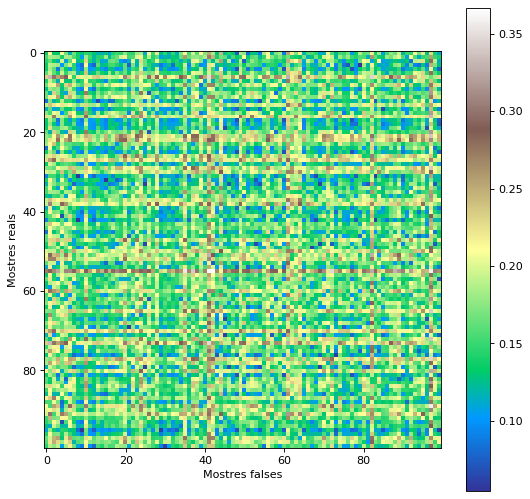

Average ----> 0.17
 
 
 
JS distance real-real:
 
[[0.    0.161 0.149 ... 0.235 0.23  0.171]
 [0.161 0.    0.199 ... 0.161 0.189 0.14 ]
 [0.149 0.199 0.    ... 0.247 0.237 0.172]
 ...
 [0.235 0.161 0.247 ... 0.    0.131 0.179]
 [0.23  0.189 0.237 ... 0.131 0.    0.193]
 [0.171 0.14  0.172 ... 0.179 0.193 0.   ]]
 


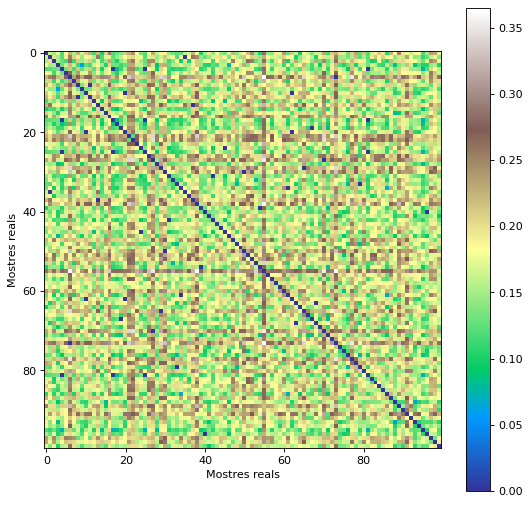

Average ----> 0.185
 
 
 
JS distance fake-fake:
 
[[0.    0.161 0.121 ... 0.243 0.115 0.132]
 [0.161 0.    0.216 ... 0.348 0.219 0.203]
 [0.121 0.216 0.    ... 0.258 0.169 0.119]
 ...
 [0.243 0.348 0.258 ... 0.    0.197 0.221]
 [0.115 0.219 0.169 ... 0.197 0.    0.141]
 [0.132 0.203 0.119 ... 0.221 0.141 0.   ]]
 


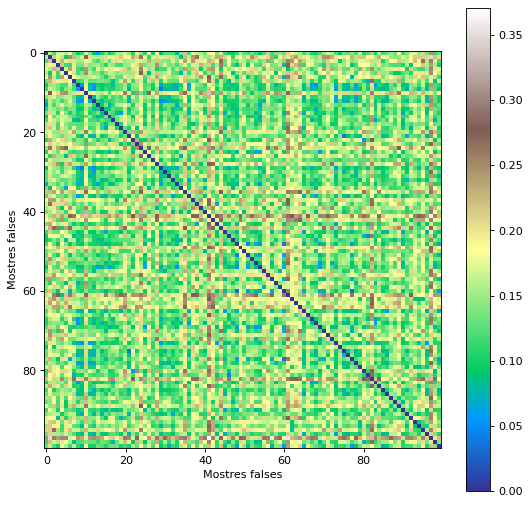

 
Average ----> 0.154


In [51]:
#In probability theory and statistics, the Jensen–Shannon divergence is a method 
#of measuring the similarity between two probability distributions. It is also known as
#information radius (IRad) or total divergence to the average. 
#It is based on the Kullback–Leibler divergence, with some notable (and useful) differences, 
#including that it is symmetric and it always has a finite value. 
#The square root of the Jensen–Shannon divergence is a metric often referred to as Jensen-Shannon distance

img_size = 8
print('In Real-Real and Fake-Fake matrix values of equal')
print('distributions are omited when calculating the mean')
print(' ')
print(' ')
print(' ')
#JS-pq
print('JS distance real-fake:')
print(' ')
print(np.around(corr_matrix_js_pq, decimals=3))
print(' ')
print(' ')
#print('Average ---->', np.around(np.mean(corr_matrix_js_pq), decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_js_pq,cmap='terrain')
plt.colorbar()
plt.xlabel('Mostres falses')
plt.ylabel('Mostres reals')
plt.show()
corr_matrix_js_pq[corr_matrix_js_pq == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_js_pq), decimals=3))
print(' ')
print(' ')
print(' ')
print('JS distance real-real:')
print(' ')
print(np.around(corr_matrix_js_pq_real, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_js_pq_real,cmap='terrain')
plt.colorbar()
plt.xlabel('Mostres reals')
plt.ylabel('Mostres reals')
plt.show()
corr_matrix_js_pq_real[corr_matrix_js_pq_real == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_js_pq_real), decimals=3))
print(' ')
print(' ')
print(' ')
print('JS distance fake-fake:')
print(' ')
print(np.around(corr_matrix_js_pq_fake, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_js_pq_fake,cmap='terrain')
plt.colorbar()
plt.xlabel('Mostres falses')
plt.ylabel('Mostres falses')
plt.show()
print(' ')
corr_matrix_js_pq_fake[corr_matrix_js_pq_fake == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_js_pq_fake), decimals=3))

In Real-Real and Fake-Fake matrix values of equal
distributions are omited when calculating the mean
 
 
 
JS distance real-fake:
 
[[0.327 0.32  0.252 ... 0.337 0.207 0.28 ]
 [0.255 0.205 0.195 ... 0.296 0.27  0.185]
 [0.247 0.252 0.172 ... 0.316 0.202 0.183]
 ...
 [0.248 0.28  0.237 ... 0.139 0.275 0.331]
 [0.251 0.272 0.142 ... 0.187 0.141 0.243]
 [0.275 0.311 0.193 ... 0.321 0.187 0.216]]
 
 
 


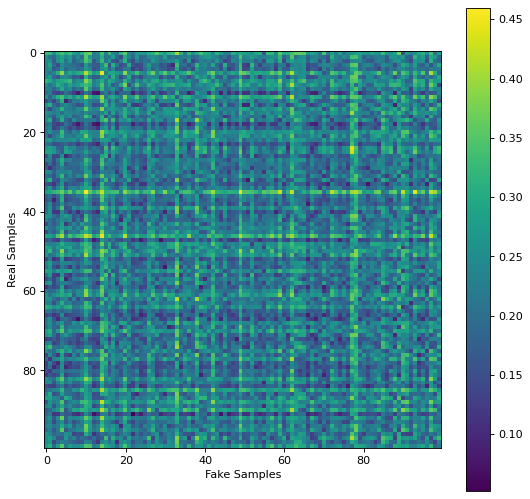

Average ----> 0.226
 
 
 
JS distance real-real:
 
[[  nan 0.296 0.2   ... 0.335 0.234 0.214]
 [0.296   nan 0.211 ... 0.284 0.242 0.258]
 [0.2   0.211   nan ... 0.322 0.208 0.156]
 ...
 [0.335 0.284 0.322 ...   nan 0.224 0.35 ]
 [0.234 0.242 0.208 ... 0.224   nan 0.226]
 [0.214 0.258 0.156 ... 0.35  0.226   nan]]
 


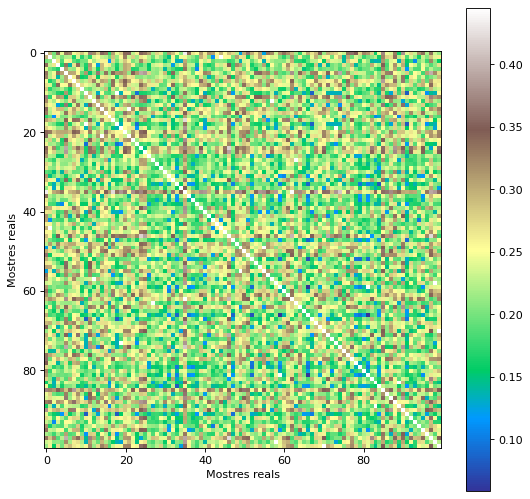

Average ----> 0.231
 
 
 
JS distance fake-fake:
 
[[  nan 0.175 0.176 ... 0.286 0.259 0.228]
 [0.175   nan 0.201 ... 0.325 0.3   0.17 ]
 [0.176 0.201   nan ... 0.226 0.154 0.179]
 ...
 [0.286 0.325 0.226 ...   nan 0.22  0.338]
 [0.259 0.3   0.154 ... 0.22    nan 0.265]
 [0.228 0.17  0.179 ... 0.338 0.265   nan]]
 


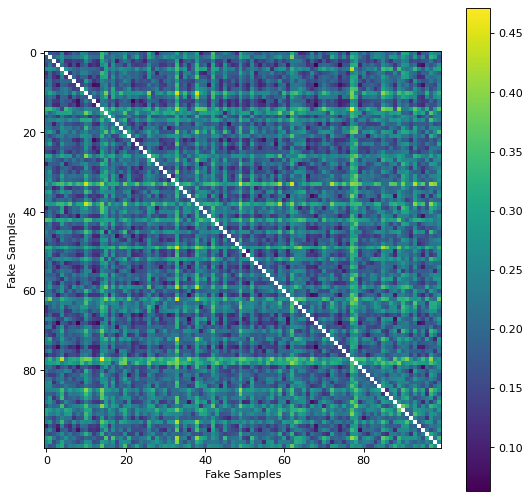

 
Average ----> 0.216


In [44]:
#In probability theory and statistics, the Jensen–Shannon divergence is a method 
#of measuring the similarity between two probability distributions. It is also known as
#information radius (IRad) or total divergence to the average. 
#It is based on the Kullback–Leibler divergence, with some notable (and useful) differences, 
#including that it is symmetric and it always has a finite value. 
#The square root of the Jensen–Shannon divergence is a metric often referred to as Jensen-Shannon distance

img_size = 8
print('In Real-Real and Fake-Fake matrix values of equal')
print('distributions are omited when calculating the mean')
print(' ')
print(' ')
print(' ')
#JS-pq
print('JS distance real-fake:')
print(' ')
print(np.around(corr_matrix_js_pq, decimals=3))
print(' ')
print(' ')
#print('Average ---->', np.around(np.mean(corr_matrix_js_pq), decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_js_pq)
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Real Samples')
plt.show()
corr_matrix_js_pq[corr_matrix_js_pq == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_js_pq), decimals=3))
print(' ')
print(' ')
print(' ')
print('JS distance real-real:')
print(' ')
print(np.around(corr_matrix_js_pq_real, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_js_pq_real,cmap='terrain')
plt.colorbar()
plt.xlabel('Mostres reals')
plt.ylabel('Mostres reals')
plt.show()
corr_matrix_js_pq_real[corr_matrix_js_pq_real == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_js_pq_real), decimals=3))
print(' ')
print(' ')
print(' ')
print('JS distance fake-fake:')
print(' ')
print(np.around(corr_matrix_js_pq_fake, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_js_pq_fake)
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Fake Samples')
plt.show()
print(' ')
corr_matrix_js_pq_fake[corr_matrix_js_pq_fake == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_js_pq_fake), decimals=3))

In Real-Real and Fake-Fake matrix values of equal
distributions are omited when calculating the mean
 
 
 
KL distance real-fake:
 
[[13246.98  14430.739  8181.704 ... 20428.374  5924.732 10255.054]
 [ 8221.211 10897.871  5764.207 ... 21690.711  9429.563  4071.608]
 [10556.269  9770.751  4730.685 ... 18077.08   6258.976  6204.914]
 ...
 [10139.087 12429.524  9342.467 ...  5342.97  12391.457 19795.719]
 [ 7250.582 11296.527  2495.021 ... 11684.138  2726.572  7197.63 ]
 [ 9876.979 13333.809  4677.953 ... 18394.881  4742.664  6515.551]]
 


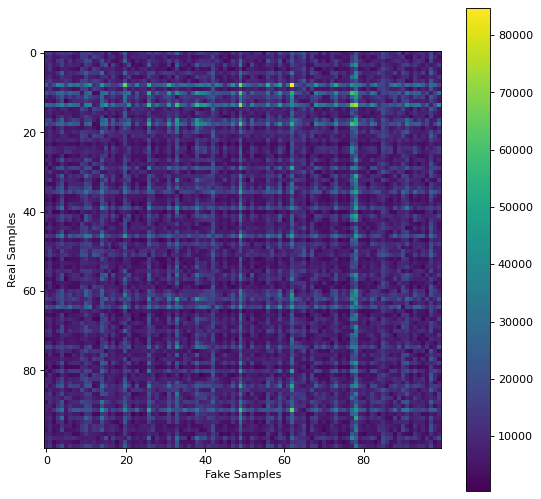

 
Average ----> 11129.065
 
 
 
KL distance real-real:
 
10898.477


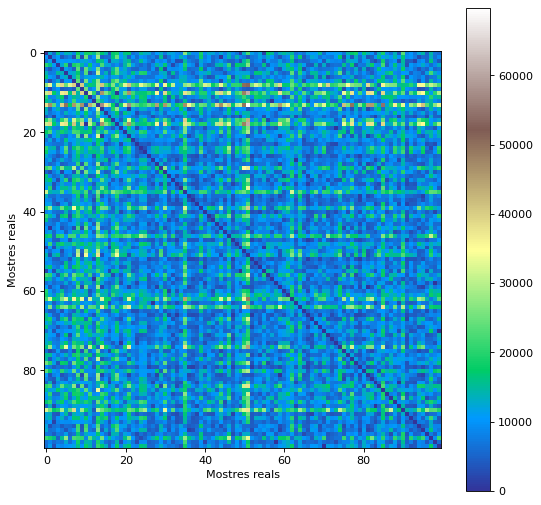

 
Average ----> 11033.08
 
 
 
KL distance fake-fake:
 
[[    0.     5707.84   3910.659 ... 17714.862 10249.76   6809.147]
 [ 6940.345     0.     8236.219 ... 19817.145 17891.078  8743.059]
 [ 4138.756  6569.848     0.    ... 12129.816  3447.641  4693.59 ]
 ...
 [22580.029 23533.708 16241.756 ...     0.    14942.429 34102.546]
 [ 8580.608 12951.741  3049.014 ... 10996.805     0.    10689.602]
 [ 6371.213  6654.252  4092.934 ... 21815.934  9061.408     0.   ]]
 


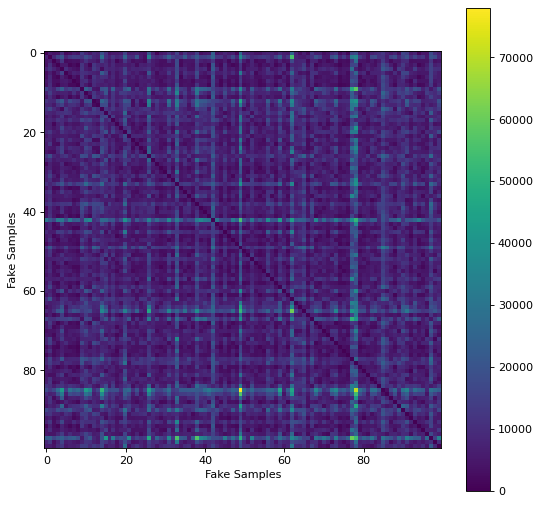

 
Average ----> 9246.596


In [46]:
#KL-pq
#En palabras, es el promedio ponderado de la diferencia 
#logarítmica entre las probabilidades P y Q,
#donde el promedio se toma usando las probabilidades P
print('In Real-Real and Fake-Fake matrix values of equal')
print('distributions are omited when calculating the mean')
print(' ')
print(' ')
print(' ')
print('KL distance real-fake:')
print(' ')
print(np.around(corr_matrix_kl_pq, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_kl_pq)
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Real Samples')
plt.show()
print(' ')
corr_matrix_kl_pq[corr_matrix_kl_pq == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_kl_pq), decimals=3))
print(' ')
print(' ')
print(' ')
print('KL distance real-real:')
print(' ')
print(np.around(np.mean(corr_matrix_kl_pq_real), decimals=3))
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_kl_pq_real,cmap='terrain')
plt.colorbar()
plt.xlabel('Mostres reals')
plt.ylabel('Mostres reals')
plt.show()
print(' ')
corr_matrix_kl_pq_real[corr_matrix_kl_pq_real == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_kl_pq_real), decimals=3))
print(' ')
print(' ')
print(' ')
print('KL distance fake-fake:')
print(' ')
print(np.around(corr_matrix_kl_pq_fake, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_kl_pq_fake)
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Fake Samples')
plt.show()
print(' ')
corr_matrix_kl_pq_fake[corr_matrix_kl_pq_fake == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_kl_pq_fake), decimals=3))

In Real-Real and Fake-Fake matrix values of equal
distributions are omited when calculating the mean
 
 
 
Variance real-fake:
 
[[-3.64  -0.173 -1.874 ... -1.479 -0.877 -1.452]
 [-0.943  0.056 -1.693 ... -1.338 -0.489 -1.509]
 [-1.148 -0.132  0.276 ...  0.15  -0.35  -0.257]
 ...
 [-1.593 -0.169 -5.351 ... -0.781 -0.095 -2.348]
 [-2.58  -0.102 -2.699 ...  0.076 -0.166 -0.838]
 [-1.424 -0.101 -3.28  ... -0.821 -0.102 -2.188]]
 


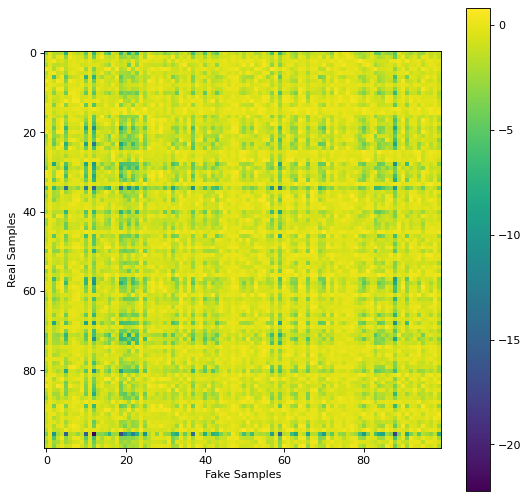

 
Average ----> -1.08
 
 
 
Variance real-real:
 
-1.3


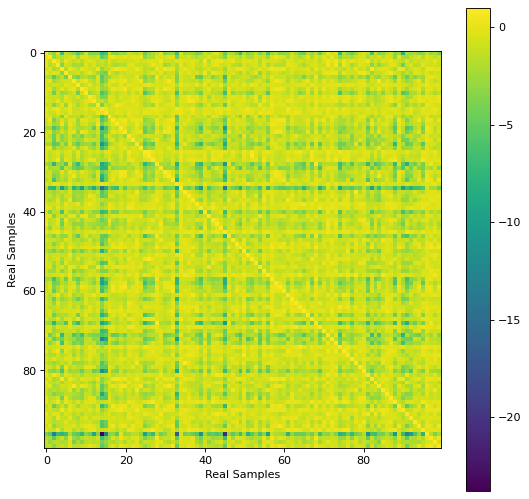

 
Average ----> -1.3
 
 
 
Variance fake-fake:
 
[[ 1.0000e+00 -9.2000e-02 -2.2580e+00 ... -5.9500e-01 -1.1600e-01
  -1.0430e+00]
 [-1.9812e+01  1.0000e+00 -2.8755e+01 ... -1.0830e+01 -2.8250e+00
  -1.4314e+01]
 [-1.2690e+00 -8.8000e-02  1.0000e+00 ... -6.0700e-01 -3.9800e-01
  -4.5900e-01]
 ...
 [-1.9980e+00 -1.6700e-01 -3.3360e+00 ...  1.0000e+00 -5.3900e-01
  -1.4650e+00]
 [-4.6790e+00 -2.2000e-02 -9.2170e+00 ... -3.1690e+00  1.0000e+00
  -2.2380e+00]
 [-1.4450e+00  3.8000e-02 -1.5070e+00 ... -5.7000e-01  2.3900e-01
   1.0000e+00]]
 


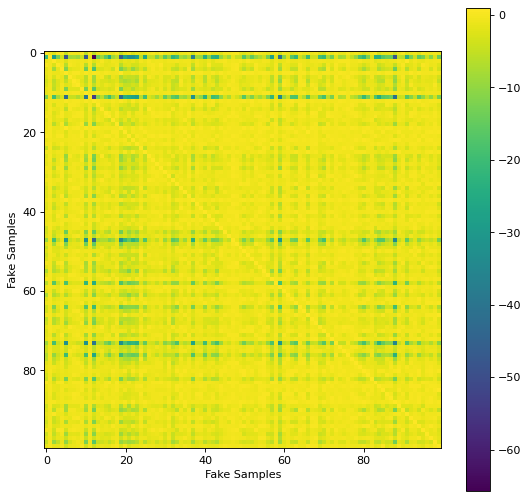

 
Average ----> -1.879


In [41]:
#KL-pq
#En palabras, es el promedio ponderado de la diferencia 
#logarítmica entre las probabilidades P y Q,
#donde el promedio se toma usando las probabilidades P
print('In Real-Real and Fake-Fake matrix values of equal')
print('distributions are omited when calculating the mean')
print(' ')
print(' ')
print(' ')
print('Variance real-fake:')
print(' ')
print(np.around(var_matrix_pq, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(var_matrix_pq)
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Real Samples')
plt.show()
print(' ')
var_matrix_pq[var_matrix_pq == 0] = np.nan
print('Average ---->', np.around(np.nanmean(var_matrix_pq), decimals=3))
print(' ')
print(' ')
print(' ')
print('Variance real-real:')
print(' ')
print(np.around(np.mean(var_matrix_pq_real), decimals=3))
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(var_matrix_pq_real)
plt.colorbar()
plt.xlabel('Real Samples')
plt.ylabel('Real Samples')
plt.show()
print(' ')
var_matrix_pq_real[var_matrix_pq_real == 0] = np.nan
print('Average ---->', np.around(np.nanmean(var_matrix_pq_real), decimals=3))
print(' ')
print(' ')
print(' ')
print('Variance fake-fake:')
print(' ')
print(np.around(var_matrix_pq_fake, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(var_matrix_pq_fake)
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Fake Samples')
plt.show()
print(' ')
var_matrix_pq_fake[var_matrix_pq_fake == 0] = np.nan
print('Average ---->', np.around(np.nanmean(var_matrix_pq_fake), decimals=3))

In [42]:
print('Mean Absolute Deviation:')
print(' ')
#print('Fake:',np.around(mad_matrix_fake, decimals=3))
#print(' ')
print('Average Fake ---->', np.around(np.mean(mad_matrix_fake),decimals=3))
#print(' ')
#print(' ')
#print('Real',np.around(mad_matrix_real, decimals=3))
#print(' ')
print('Average Real ---->',np.around(np.mean(mad_matrix_real),decimals=3))
print(' ')
print(' ')
#print(' ')
print('Standard Deviation:')
print(' ')
#print('Fake:',np.around(sd_matrix_fake, decimals=3))
#print(' ')
print('Average Fake ---->', np.around(np.mean(sd_matrix_fake),decimals=3))
#print(' ')
#print(' ')
#print('Real',np.around(sd_matrix_real, decimals=3))
#print(' ')
print('Average Real ---->',np.around(np.mean(sd_matrix_real),decimals=3))

Mean Absolute Deviation:
 
Average Fake ----> 47.036
Average Real ----> 54.289
 
 
Standard Deviation:
 
Average Fake ----> 57.396
Average Real ----> 65.584


Text(0, 0.5, 'Glucosa en sang')

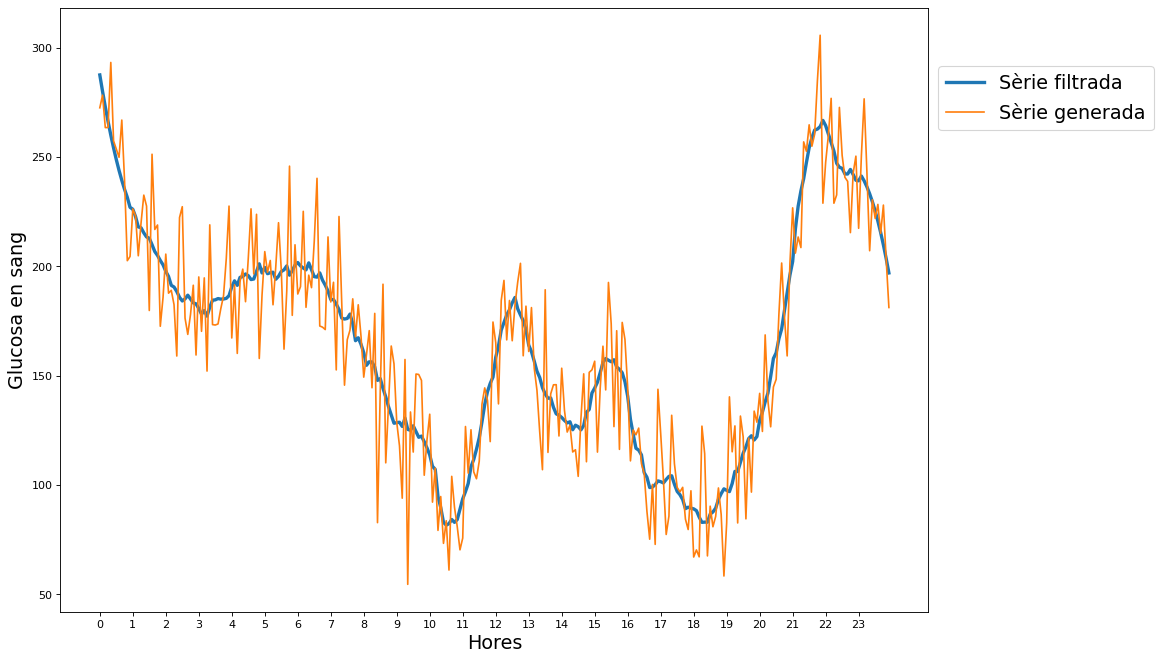

In [49]:
a=4
hourtick=np.zeros((x_real.shape[1]))
xaxis=[]
xaxis_label=[]
for j in range(x_real.shape[1]):
    if j%12==0:
        hourtick[j]=40
        xaxis.append(j)
        xaxis_label.append(int(j/12))
        
#xaxis_label=str(xaxis_label)        

#plt.scatter(x_axis,x_fake[1])
figure(figsize=(14, 10), dpi=80)
plt.plot(fake_smooth[a], label='Sèrie filtrada',linewidth=3.0)
plt.plot(x_fake[a],label = 'Sèrie generada')
plt.plot(x_real[a],label = 'Sèrie Real',linewidth=3.0)
plt.plot(hourtick, label = 'Hores')
plt.legend(loc='center left', bbox_to_anchor=(1,0.85),fontsize='xx-large')
plt.xticks(xaxis,xaxis_label)
plt.xlabel('Hores', fontsize='xx-large')
plt.ylabel('Glucosa en sang', fontsize='xx-large')

In [ ]:
n_samples=100
#x_fake, y_fake = generate_fake_samples(model, latent_dim, n_samples)
#x_real, y_real = generate_real_samples(dataset, n_samples)

#x_fake=scaler.inverse_transform(x_fake)
#x_real=scaler.inverse_transform(x_real)

to_severe=0
to_topval=0

fake_smooth = fake_smoothing(x_fake)
total=fake_smooth.shape[0]*fake_smooth.shape[1]       

print('Data Outside Range [40-500], not cleaned ---->',hypocountrealscale(x_real)[3], '---->', 100*hypocountrealscale(x_real)[3]/total,'%')
print(' ')
print('Data Outside the Range not considered as data with Hypos')
print(' ')
print('Real Data Hypos:')
print('1 Hypo ---->',hypocountrealscale(x_real)[1], '---->', 100*hypocountrealscale(x_real)[1]/total,'%')
print('2 Hypo ---->',hypocountrealscale(x_real)[2], '---->', 100*hypocountrealscale(x_real)[2]/total,'%')
print('Normal Range ---->',hypocountrealscale(x_real)[0], '---->', 100*hypocountrealscale(x_real)[0]/total,'%')
print('Hyper ---->',hypocountrealscale(x_real)[6], '---->', 100*hypocountrealscale(x_real)[6]/total,'%')

print('NO HYPO ---->',hypocountrealscale(x_real)[6]+hypocountrealscale(x_real)[0], '---->', 100*(hypocountrealscale(x_real)[6]+hypocountrealscale(x_real)[0])/total,'%')

print(' ')
print('Fake Data Hypos:')
print('Data Outside Range [40-500], not cleaned ---->',hypocountrealscale(fake_smooth)[3], '---->', 100*hypocountrealscale(fake_smooth)[3]/total,'%')

print('1 Hypo ---->',hypocountrealscale(fake_smooth)[1], '---->', 100*hypocountrealscale(fake_smooth)[1]/total,'%')
print('2 Hypo ---->',hypocountrealscale(fake_smooth)[2], '---->', 100*hypocountrealscale(fake_smooth)[2]/total,'%')
print('Normal Range ---->',hypocountrealscale(fake_smooth)[0], '---->', 100*hypocountrealscale(fake_smooth)[0]/total,'%')
print('Hyper Range ---->',hypocountrealscale(fake_smooth)[6], '---->', 100*hypocountrealscale(fake_smooth)[6]/total,'%')

print('No HYPO ---->',hypocountrealscale(fake_smooth)[6]+hypocountrealscale(fake_smooth)[0], '---->', 100*(hypocountrealscale(fake_smooth)[6]+hypocountrealscale(fake_smooth)[0])/total,'%')

In [ ]:
   return (range70_120,  range54_70, range40_54 , range25_40, rangeout, nonvalid, range120_500)

In [ ]:
n_samples=len(dataset)
#x_fake, y_fake = generate_fake_samples(model, latent_dim, n_samples)
#x_real, y_real = generate_real_samples(dataset, n_samples)

#x_fake=scaler.inverse_transform(x_fake)
#x_real=scaler.inverse_transform(x_real)

to_severe=0
to_topval=0

total=len(dataset)*288      

print('Data Outside Range [40-500], not cleaned ---->',hypocountrealscale(dataset)[3], '---->', 100*hypocountrealscale(dataset)[3]/total,'%')
print('Real Data Hypos:')
print('Miled Hypo ---->',hypocountrealscale(dataset)[1], '---->', 100*hypocountrealscale(dataset)[1]/total,'%')
print('Severe Hypo ---->',hypocountrealscale(dataset)[2], '---->', 100*hypocountrealscale(dataset)[2]/total,'%')
print('Normal Range ---->',hypocountrealscale(dataset)[0], '---->', 100*hypocountrealscale(dataset)[0]/total,'%')
print('Hyper ---->',hypocountrealscale(dataset)[6], '---->', 100*hypocountrealscale(dataset)[6]/total,'%')



In [ ]:
n_samples=len(dataset)
#x_fake, y_fake = generate_fake_samples(model, latent_dim, n_samples)
#x_real, y_real = generate_real_samples(dataset, n_samples)

#x_fake=scaler.inverse_transform(x_fake)
#x_real=scaler.inverse_transform(x_real)

to_severe=0
to_topval=0

fake_smooth = fake_smoothing(x_fake)
total=fake_smooth.shape[0]*fake_smooth.shape[1]       

print('Data Outside Range [40-500], not cleaned ---->',(hypocountrealscale(fake_smooth)[5]),'/',n_samples, '---->', (hypocountrealscale(fake_smooth)[5])/n_samples,'%')
print(' ')
print('Data Outside the Range not considered as data with Hypos')
print(' ')
print('Real Data Hypos:')
print('Miled Hypo ---->',hypocountrealscale(x_real)[1], '---->', 100*hypocountrealscale(x_real)[1]/total,'%')
print('Severe Hypo ---->',(hypocountrealscale(x_real)[2]+hypocountrealscale(x_real)[3]), '---->', 100*(hypocountrealscale(x_real)[2]+hypocountrealscale(x_real)[3])/total,'%')
print('Normal Range ---->',hypocountrealscale(x_real)[0], '---->', 100*hypocountrealscale(x_real)[0]/total,'%')
print('Hyper ---->',hypocountrealscale(x_real)[6], '---->', 100*hypocountrealscale(x_real)[6]/total,'%')

print('NO HYPO ---->',hypocountrealscale(x_real)[6]+hypocountrealscale(x_real)[0], '---->', 100*(hypocountrealscale(x_real)[6]+hypocountrealscale(x_real)[0])/total,'%')


In [ ]:
severe_real=100*hypocountrealscale(dataset)[5]/(len(dataset)*288)
severe_fake=100*hypocountrealscale(fake_smooth)[5]/(len(fake_smooth)*288)
print('ERROR:')
#print('Miled Hypo ---->', 100*abs(hypocountrealscale(x_real)[1]-hypocountrealscale(fake_smooth)[1])/hypocountrealscale(x_real)[1],'%')
print('Severe Hypo ---->',100*abs(severe_real-severe_fake)/severe_real,'%')
#print('NO Hypo ---->',100*abs(hypocountrealscale(x_real)[0]-hypocountrealscale(fake_smooth)[0])/hypocountrealscale(x_real)[0],'%')


In [ ]:
figure(figsize=(14, 10), dpi=80)
for i in range(n_samples):
    
    plt.plot(fake_smooth[i])
plt.show()

In Real-Real and Fake-Fake matrix values of equal
distributions are omited when calculating the mean
 
 
 
Z-Test real-fake:
 
[[ 0.3    1.768 -0.389 ...  0.308  1.401  0.288]
 [-0.152  0.626 -0.71  ... -0.222  0.484 -0.185]
 [-0.011  0.616 -0.507 ... -0.05   0.514 -0.033]
 ...
 [ 0.197  1.457 -0.461 ...  0.182  1.166  0.179]
 [ 0.74   2.228  0.033 ...  0.829  1.887  0.752]
 [-0.012  0.923 -0.61  ... -0.065  0.737 -0.041]]
 
 
 


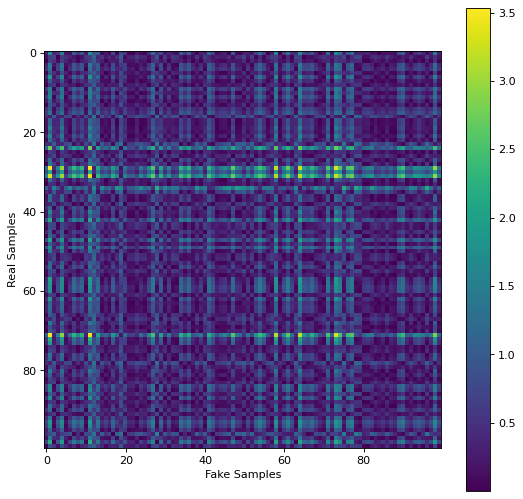

Average ----> 0.541
 
 
 
Z-Test real-real:
 
[[ 0.     0.491  0.257 ...  0.12  -0.582  0.349]
 [-0.491  0.    -0.12  ... -0.38  -0.93  -0.151]
 [-0.257  0.12   0.    ... -0.175 -0.627 -0.001]
 ...
 [-0.12   0.38   0.175 ...  0.    -0.666  0.233]
 [ 0.582  0.93   0.627 ...  0.666  0.     0.828]
 [-0.349  0.151  0.001 ... -0.233 -0.828  0.   ]]
 


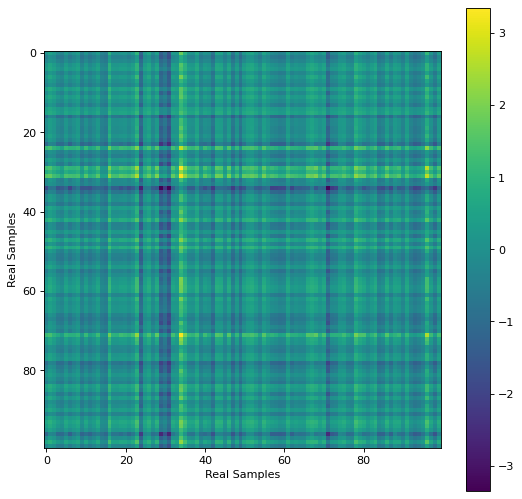

Average ----> 0.468
 
 
 
Z-Test fake-fake:
 
[[ 0.     0.779 -0.555 ... -0.05   0.637 -0.029]
 [-0.779  0.    -1.371 ... -1.121 -0.197 -0.886]
 [ 0.555  1.371  0.    ...  0.574  1.227  0.548]
 ...
 [ 0.05   1.121 -0.574 ...  0.     0.885  0.018]
 [-0.637  0.197 -1.227 ... -0.885  0.    -0.722]
 [ 0.029  0.886 -0.548 ... -0.018  0.722  0.   ]]
 


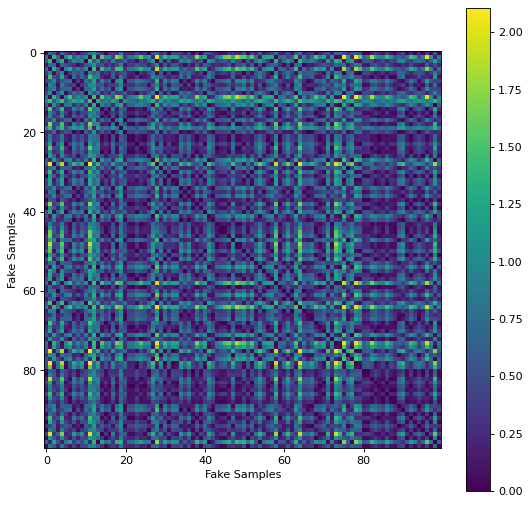

 
Average ----> 0.528


In [60]:
#In probability theory and statistics, the Jensen–Shannon divergence is a method 
#of measuring the similarity between two probability distributions. It is also known as
#information radius (IRad) or total divergence to the average. 
#It is based on the Kullback–Leibler divergence, with some notable (and useful) differences, 
#including that it is symmetric and it always has a finite value. 
#The square root of the Jensen–Shannon divergence is a metric often referred to as Jensen-Shannon distance

img_size = 8
print('In Real-Real and Fake-Fake matrix values of equal')
print('distributions are omited when calculating the mean')
print(' ')
print(' ')
print(' ')
#JS-pq
print('Z-Test real-fake:')
print(' ')
print(np.around(zs_matrix, decimals=3))
print(' ')
print(' ')
#print('Average ---->', np.around(np.mean(corr_matrix_js_pq), decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(abs(zs_matrix))
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Real Samples')
plt.show()
#zs_matrix[zs_matrix == 0] = np.nan
print('Average ---->', np.around(np.nanmean(abs(zs_matrix)), decimals=3))
print(' ')
print(' ')
print(' ')
print('Z-Test real-real:')
print(' ')
print(np.around(zs_matrix_real, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(zs_matrix_real)
plt.colorbar()
plt.xlabel('Real Samples')
plt.ylabel('Real Samples')
plt.show()
#zs_matrix_real[zs_matrix_real == 0] = np.nan
print('Average ---->', np.around(spec_mean(zs_matrix_real), decimals=3))
print(' ')
print(' ')
print(' ')
print('Z-Test fake-fake:')
print(' ')
print(np.around(zs_matrix_fake, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(abs(zs_matrix_fake))
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Fake Samples')
plt.show()
print(' ')
#zs_matrix_fake[zs_matrix_fake == 0] = np.nan
print('Average ---->', np.around(spec_mean(zs_matrix_fake), decimals=3))

In [ ]:
figure(figsize=(14, 10), dpi=80)
for i in range (4)
plt.plot(fake_smooth[a], label='Sèrie filtrada',linewidth=3.0)
plt.plot(x_fake[a],label = 'Sèrie generada')
#plt.plot(x_real[a],label = 'Real',linewidth=3.0)
#plt.plot(hourtick, label = 'Hour')
plt.legend(loc='center left', bbox_to_anchor=(1,0.85),fontsize='xx-large')
plt.xticks(xaxis,xaxis_label)
plt.xlabel('Hores', fontsize='xx-large')
plt.ylabel('Glucosa en sang', fontsize='xx-large')

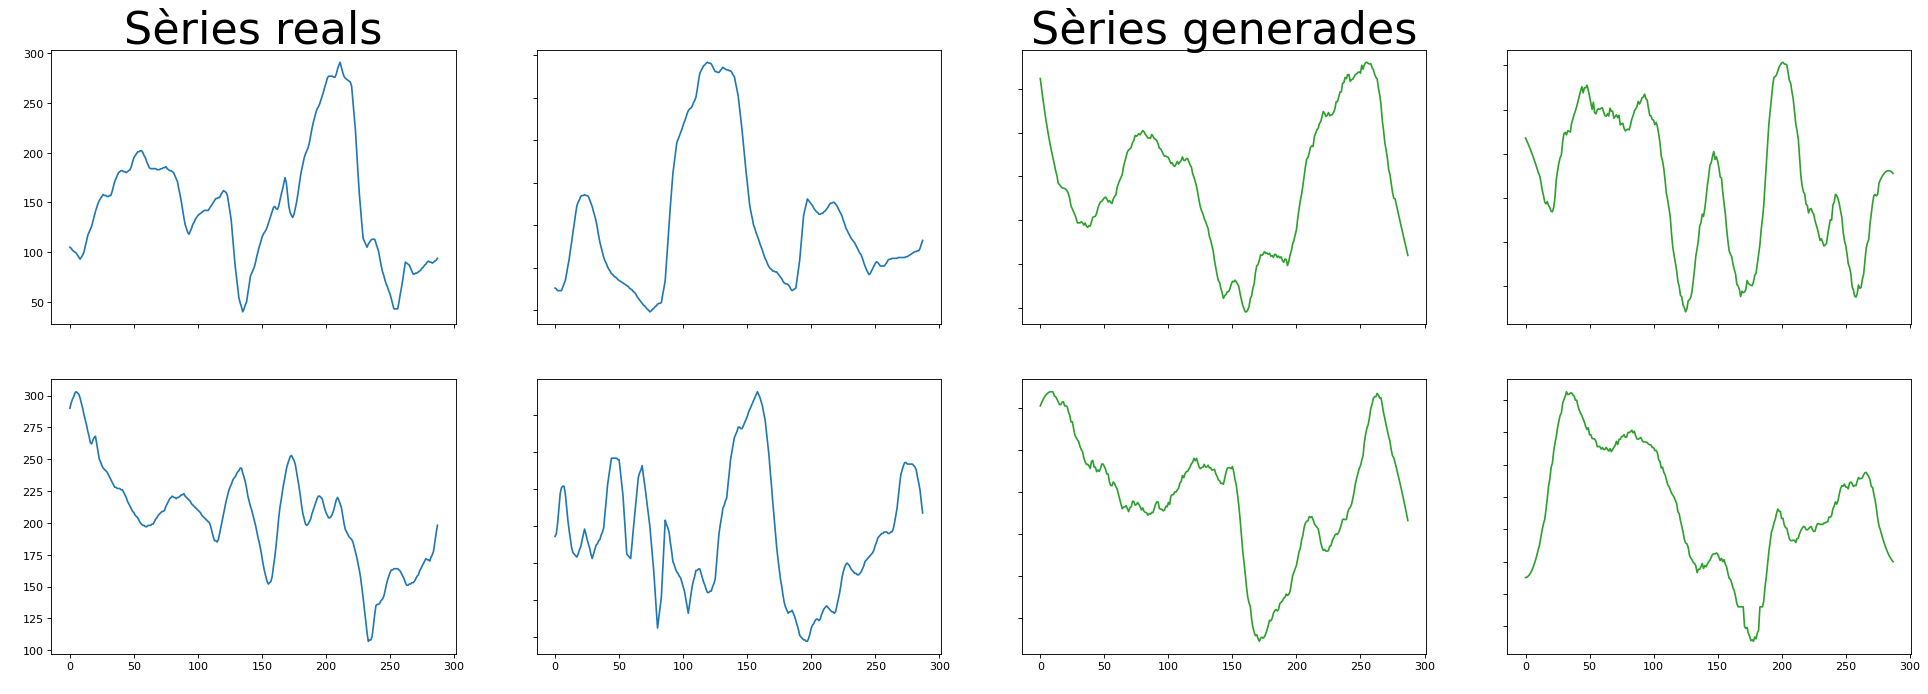

In [58]:
def fake_smoothing(fake):
    fake_smooth=np.ones((fake.shape[0],fake.shape[1]))
    for i in range (fake.shape[0]):
        fake_smooth[i] = savgol_filter(fake[i], 21, 2)  # high frequency noise removed
    return fake_smooth

x_fake, y_fake = generate_fake_samples(model, latent_dim, n_samples)
x_real, y_real = generate_real_samples(dataset, n_samples)

#x_fake=scaler.inverse_transform(x_fake)
#x_real=scaler.inverse_transform(x_real)

fake_smooth = fake_smoothing(x_fake)
for i in range(fake_smooth.shape[0]):
    for j in range(fake_smooth.shape[1]):
        if fake_smooth[i][j] <=40 and fake_smooth[i][j]>25:
            fake_smooth[i][j] = 40
        elif fake_smooth[i][j] >= 500 and fake_smooth[i][j]<800:
            fake_smooth[i][j] = 500
        elif fake_smooth[i][j] <=0:
            fake_smooth[i][j] = 0.1


fig, axs = plt.subplots(2, 4, figsize=(30, 10),dpi=80)

axs[0, 0].plot(x_real[0])
axs[0, 0].set_title('Sèries reals',fontsize=40)
axs[0, 1].plot(x_real[5])
#axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x_real[2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x_real[3])
axs[0, 2].set_title('Sèries generades',fontsize=40)
axs[0, 2].plot(fake_smooth[0], 'tab:green')
axs[0, 3].plot(fake_smooth[1], 'tab:green')
axs[1, 2].plot(fake_smooth[2], 'tab:green')
axs[1, 3].plot(fake_smooth[3], 'tab:green')
for ax in axs.flat:
    ax.set(xlabel='  ', ylabel='  ')
for ay in axs.flat:
    ay.set(xlabel='  ', ylabel='  ')
for ax in fig.get_axes():
    ax.label_outer()
for ay in fig.get_axes():
    ay.label_outer()

In [ ]:
a=4
hourtick=np.zeros((x_real.shape[1]))
xaxis=[]
xaxis_label=[]
for j in range(x_real.shape[1]):
    if j%12==0:
        hourtick[j]=40
        xaxis.append(j)
        xaxis_label.append(int(j/12))
        
#xaxis_label=str(xaxis_label)        

#plt.scatter(x_axis,x_fake[1])
figure(figsize=(14, 10), dpi=80)
plt.plot(fake_smooth[a], label='Sèrie filtrada',linewidth=3.0)
plt.plot(x_fake[a],label = 'Sèrie generada')
#plt.plot(x_real[a],label = 'Real',linewidth=3.0)
#plt.plot(hourtick, label = 'Hour')
plt.legend(loc='center left', bbox_to_anchor=(1,0.85),fontsize='xx-large')
plt.xticks(xaxis,xaxis_label)
plt.xlabel('Hores', fontsize='xx-large')
plt.ylabel('Glucosa en sang', fontsize='xx-large')